# CWSL vs RMSE: Asymmetric Forecast Evaluation Demo

This example illustrates how **Cost-Weighted Service Loss (CWSL)** can
prefer a forecast that is operationally better, even when traditional
symmetric metrics (RMSE, wMAPE) say the opposite.

We will:

- Create a small synthetic demand pattern (a "peak" period).
- Build two simple forecasts:
  - **Model A**: slightly under-forecasts the peak (more shortfall).
  - **Model B**: slightly over-forecasts the peak (more overbuild).
- Compare:
  - RMSE and wMAPE (symmetric).
  - CWSL with an asymmetric cost ratio R = cu / co.
- Run **cost sensitivity analysis** to see how each model behaves across
  a range of R values.

In [1]:
import numpy as np
import pandas as pd

from cwsl import (
    cwsl,
    rmse,
    wmape,
    cwsl_sensitivity,
)

np.set_printoptions(suppress=True, floatmode="fixed")

# Synthetic demand: a small "peak + off-peak" pattern
y_true = np.array([10, 12, 15, 20, 25, 22, 18, 14, 10], dtype=float)

# Model A: slightly UNDER-forecasts the peak (more shortfall at high demand)
y_pred_A = np.array([9, 11, 14, 18, 22, 20, 17, 13, 10], dtype=float)

# Model B: slightly OVER-forecasts the peak (more overbuild at high demand)
y_pred_B = np.array([11, 13, 16, 22, 28, 24, 19, 15, 11], dtype=float)

df = pd.DataFrame({
    "y_true": y_true,
    "y_pred_A": y_pred_A,
    "y_pred_B": y_pred_B,
})
df

,y_true,y_pred_A,y_pred_B
0,10.0,9.0,11.0
1,12.0,11.0,13.0
2,15.0,14.0,16.0
3,20.0,18.0,22.0
4,25.0,22.0,28.0
5,22.0,20.0,24.0
6,18.0,17.0,19.0
7,14.0,13.0,15.0
8,10.0,10.0,11.0


### Compare RMSE, wMAPE, and CWSL at R = 2

Here we compute:

- RMSE and wMAPE for both models (symmetric error view).
- CWSL with **R = cu / co = 2**, meaning:
  - shortfalls are 2× more costly than overbuilds.

We’ll see how the ranking can flip when we acknowledge asymmetric cost.

In [2]:
# Symmetric metrics (RMSE, wMAPE)
rmse_A = rmse(y_true, y_pred_A)
rmse_B = rmse(y_true, y_pred_B)

wmape_A = wmape(y_true, y_pred_A)
wmape_B = wmape(y_true, y_pred_B)

# Asymmetric metric: CWSL with R = cu / co = 2
R = 2.0
co = 1.0
cu = R * co

cwsl_A = cwsl(y_true, y_pred_A, cu=cu, co=co)
cwsl_B = cwsl(y_true, y_pred_B, cu=cu, co=co)

summary = pd.DataFrame(
    {
        "metric": ["RMSE", "wMAPE", "CWSL (R=2)"],
        "model_A": [rmse_A, wmape_A, cwsl_A],
        "model_B": [rmse_B, wmape_B, cwsl_B],
    }
)

summary

,metric,model_A,model_B
0,RMSE,1.563472,1.598611
1,wMAPE,0.082192,0.089041
2,CWSL (R=2),0.164384,0.089041


### Interpretation

- RMSE and wMAPE treat **shortfall** and **overbuild** symmetrically.
- CWSL with R = 2 penalizes shortfalls twice as heavily as overbuilds.

In this synthetic example:

- Model A tends to **under-forecast** the peak (more shortfall).
- Model B tends to **over-forecast** the peak (more overbuild).

It is common to see:

- Symmetric metrics slightly prefer Model A (smaller absolute errors),
- while CWSL prefers Model B, because it avoids painful shortfalls at high demand.

### Cost Sensitivity Analysis

The true cost ratio R is often uncertain. Instead of betting on a single
value, we can evaluate each model across a **range of R** and see how
robust our conclusions are.

We’ll use `cwsl_sensitivity` to evaluate each model at:

- R in {0.5, 1.0, 2.0, 3.0}

Interpretation:

- R = 0.5 → overbuild worse than shortfall
- R = 1.0 → symmetric
- R = 2.0, 3.0 → shortfall is 2×–3× worse than overbuild

In [3]:
R_list = (0.5, 1.0, 2.0, 3.0)

sens_A = cwsl_sensitivity(
    y_true=y_true,
    y_pred=y_pred_A,
    R_list=R_list,
    co=1.0,
)

sens_B = cwsl_sensitivity(
    y_true=y_true,
    y_pred=y_pred_B,
    R_list=R_list,
    co=1.0,
)

sens_df = pd.DataFrame(
    {
        "R": list(R_list),
        "CWSL_A": [sens_A[R] for R in R_list],
        "CWSL_B": [sens_B[R] for R in R_list],
    }
)

sens_df

,R,CWSL_A,CWSL_B
0,0.5,0.041096,0.089041
1,1.0,0.082192,0.089041
2,2.0,0.164384,0.089041
3,3.0,0.246575,0.089041


### Sensitivity Interpretation

- At **R < 1** (e.g., 0.5), overbuild is penalized more heavily:
  - A model that tends to overbuild will look worse.
- At **R > 1**, shortfalls become more painful:
  - Models that under-forecast peak demand start to look worse.

If Model B has lower CWSL than Model A for most R ≥ 1, you can say:

> “When shortfalls are worse than overbuilds (our operational reality),
>  Model B is the better forecast — even if symmetric metrics disagree.”


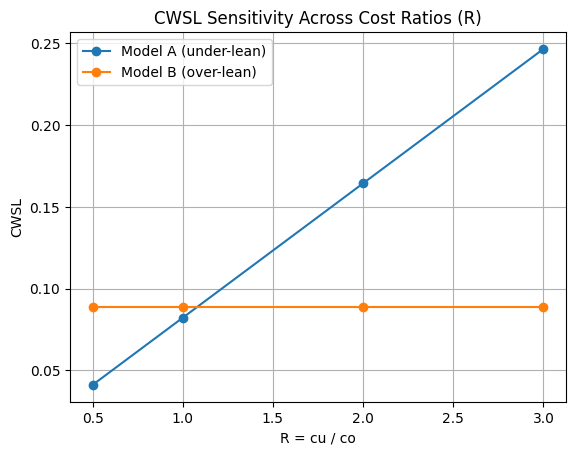

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(sens_df["R"], sens_df["CWSL_A"], marker="o", label="Model A (under-lean)")
plt.plot(sens_df["R"], sens_df["CWSL_B"], marker="o", label="Model B (over-lean)")
plt.xlabel("R = cu / co")
plt.ylabel("CWSL")
plt.title("CWSL Sensitivity Across Cost Ratios (R)")
plt.legend()
plt.grid(True)
plt.show()

### Takeaways

- Symmetric metrics (RMSE, wMAPE) can hide the operational difference
  between "often short" and "often long".
- CWSL makes the **direction and cost of errors** explicit.
- `cwsl_sensitivity` shows how each model behaves under different
  cost assumptions, and helps you:
  - pick a model that is robust across a plausible R-range;
  - justify your choice to stakeholders with different cost views.